# Bayesian Thermostat

In [1]:
using Random
Random.seed!(51233) # Set random seed

using PyPlot
using ForneyLab

include("environment.jl") # Load environmental dynamics (initializeWorld)
include("helpers.jl") # Load visualization (plotTrajectory)
;

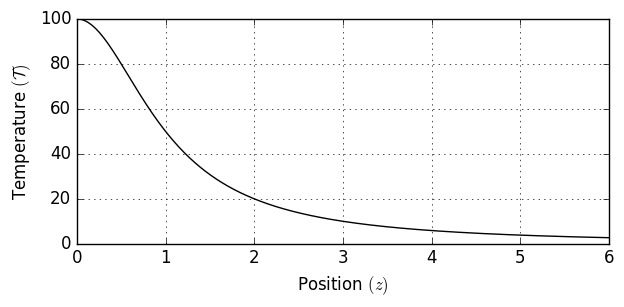

In [2]:
plotLandscape() # Visualize (hidden) temperature landscape

savefig("./figures/bt_landscape.png", dpi=300)
;

In [3]:
N = 100 # Total simulation time
T = 2 # Lookahead
action_onset = 25 # Actions are only allowed after a specific time

include("agent.jl") # Load agent prior beliefs (initializeAgent)

# Internal model parameters
gamma = 100.0 # State transition precision
theta = 0.01 # Observation variance
;

In [4]:
# Build internal model
fg = FactorGraph()

x = Vector{Variable}(undef, T) # Observed states
s = Vector{Variable}(undef, T) # Brain states
u = Vector{Variable}(undef, T) # Control states

@RV s_t_min ~ GaussianMeanVariance(placeholder(:m_s_t_min),
                                   placeholder(:v_s_t_min)) # Prior brain state
s_k_min = s_t_min
for k = 1:T # For present and future timepoints
    @RV u[k] ~ GaussianMeanVariance(placeholder(:m_u, var_id=:m_u_*k, index=k), 
                                    placeholder(:v_u, var_id=:v_u_*k, index=k)) # Control prior
    @RV s[k] ~ GaussianMeanPrecision(s_k_min + u[k], gamma) # State transition model
    @RV x[k] ~ GaussianMeanVariance(-1.0*s[k], theta) # Observation model
    GaussianMeanVariance(x[k], 
                         placeholder(:m_x, var_id=:m_x_*k, index=k), 
                         placeholder(:v_x, var_id=:v_x_*k, index=k)) # Goal prior
    s_k_min = s[k]
end
;

In [5]:
# Find the index of the slide message in the schedule
# If you alter the model, make sure to pass the correct message during the slide step
schedule = sumProductSchedule([s; u])
slide_msg_idx = findMessageIndex(schedule, :equ_s_1_1, 3)
;

In [6]:
# Compile message passing algorithm
algo = sumProductAlgorithm([s; u]) # Infer internal states
eval(Meta.parse(algo)) # This evaluation loads the step!() function for inference
include("helpers.jl")
inspectSnippet(algo) # Print a snippet of the automatically generated algorithm code
;

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 20))

messages[1] = ruleSPGaussianMeanVarianceOutVPP(nothing, Message(Univariate, PointMass, m=data[:m_s_t_min]), Message(Univariate, PointMass, m=data[:v_s_t_min]))
messages[2] = ruleSPGaussianMeanVarianceOutVPP(nothing, Message(Univariate, PointMass, m=data[:m_u][1]), Message(Univariate, PointMass, m=data[:v_u][1]))
messages[3] = ruleSPAdditionOutVGG(nothing, messages[1], messages[2])

...

marginals[:u_1] = messages[2].dist * messages[19].dist
marginals[:u_2] = messages[9].dist * messages[20].dist

return marginals

end


In [7]:
(execute, observe)  = initializeWorld() # Let there be a world
(infer, act, slide) = initializeAgent() # Let there be an agent

# Step through the experimental protocol
a = Vector{Float64}(undef, N) # Actions
y = Vector{Float64}(undef, N) # Environmental outcomes
for t = 1:N
    a[t] = (t > action_onset) ? act() : 0.0 # Evoke an action from the agent when it's time
           execute(a[t]) # The action influences hidden external states
    y[t] = observe() # Observe the current environmental outcome (update p)
           infer(a[t], y[t]) # Infer beliefs from current model state (update q)
           slide(slide_msg_idx) # Prepare model for next iteration
end
;

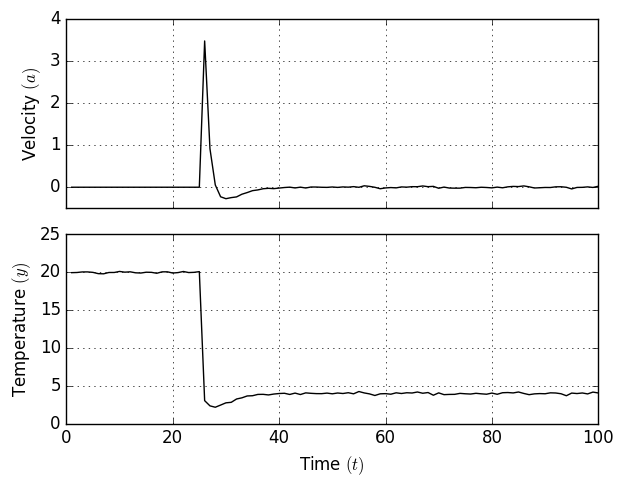

In [8]:
plotTrajectory(a, y)

savefig("./figures/bt_trajectory.png", dpi=300)
;